In [23]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn import model_selection
from sklearn.datasets import make_circles
import plotly.graph_objects as go
from numba import njit

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    auc
)

데이터 및 상수 생성

In [24]:
n_train = 50

X, Y = make_circles(n_samples = 200, noise=0.1, random_state = 42)
print(X.shape)
X_train = X[:n_train, :]
X_test = X[n_train:, :]
y_train = Y[:n_train] 
y_test = Y[n_train:]

y_train = 2 * y_train - 1
y_test = 2 * y_test - 1

(200, 2)


In [25]:
B = 10
K = 3
xi = 1
N_train = X_train.shape[0]

Q metric 생성

In [26]:
@njit
def Linear_kernel(n,m,X_1, X_2):
    P = X_1[n,:] @ X_2[m,:].T

    return(P)

In [27]:
def Q_metric():
    Q = np.zeros((K*N_train,K*N_train))

    K_train_train = np.zeros((N_train, N_train))
    for n in range(N_train):
        for m in range(N_train):
            K_train_train[n, m] = Linear_kernel(n, m,  X_train, X_train)

    for n in range(N_train):
        for m in range(N_train):
            for k in range(K):
                for j in range(K):  
                    Q[K*n + k, K*m + j] = 0.5 * (B**(k+j)) * y_train[n] * y_train[m] * (Linear_kernel(n, m, X_train, X_train) + xi)

                    if n == m and k == j:
                        Q[K*n + k, K*m + j] += -B**k

    return K_train_train, Q

solver 구하기

In [ ]:
def solve_qubo_from_array_fast(
    Q,
    time_limit=600,
    mip_gap=None,
    threads= None,
    presolve=None,
    method=None,
    symmetric_assumed=True,
    eps=0.0,
    verbose=True,
):
    """
    Solve: min x^T Q x  s.t. x in {0,1}^n  usining only nonzero terms.
g Gurobi
    Faster model build than naive O(n^2) scanning by add
    Parameters
    ----------
    Q : array-like, shape (n, n)
        QUBO matrix.
    time_limit : float or None
    mip_gap : float or None
    threads : int or None
    presolve : int or None
        Gurobi Presolve (e.g., 0/1/2).
    method : int or None
        Gurobi Method parameter for continuous relaxations (e.g., -1 auto).
    symmetric_assumed : bool
        If True, treats Q as symmetric and builds objective from upper triangle (i<=j) only.
        If Q is not symmetric and you still set True, the objective corresponds to using upper
        triangle only (not x^T Q x for nonsymmetric Q). If False, uses all nonzeros in Q.
    eps : float
        Treat |Q_ij| <= eps as zero.
    verbose : bool
        If False, suppress Gurobi output.

    Returns
    -------
    x_opt : np.ndarray, shape (n,)
        Optimal binary vector.
    energy : float
        Objective value at optimum.
    """
    Q = np.asarray(Q)
    if Q.ndim != 2 or Q.shape[0] != Q.shape[1]:
        raise ValueError("Q must be a square 2D array")
    n = Q.shape[0]

    # Optionally threshold small values to zero
    if eps > 0.0:
        Q = Q.copy()
        Q[np.abs(Q) <= eps] = 0.0

    m = gp.Model("QUBO_from_array_fast")
    if not verbose:
        m.setParam("OutputFlag", 0)

    # Optional solver parameters
    if time_limit is not None:
        m.setParam(GRB.Param.TimeLimit, float(time_limit))
    if mip_gap is not None:
        m.setParam(GRB.Param.MIPGap, float(mip_gap))
    if threads is not None:
        m.setParam(GRB.Param.Threads, int(threads))
    if presolve is not None:
        m.setParam(GRB.Param.Presolve, int(presolve))
    if method is not None:
        m.setParam(GRB.Param.Method, int(method))

    # Binary variables
    x = m.addVars(n, vtype=GRB.BINARY, name="x")

    # Build objective only from nonzeros
    if symmetric_assumed:
        # Use upper triangle indices (including diagonal)
        iu, ju = np.triu_indices(n)
        vals = Q[iu, ju]
        mask = vals != 0
        iu, ju, vals = iu[mask], ju[mask], vals[mask]

        # Objective: sum_{i<j} 2*Q_ij x_i x_j + sum_i Q_ii x_i
        # because x^T Q x with symmetric Q counts off-diagonals twice.
        obj = gp.QuadExpr()

        # Diagonal terms: Q_ii * x_i (since x_i^2 = x_i for binary)
        diag_mask = (iu == ju)
        if np.any(diag_mask):
            i_diag = iu[diag_mask]
            v_diag = vals[diag_mask]
            obj += gp.quicksum(float(v) * x[int(i)] for i, v in zip(i_diag, v_diag))

        # Off-diagonal terms
        off_mask = ~diag_mask
        if np.any(off_mask):
            i_off = iu[off_mask]
            j_off = ju[off_mask]
            v_off = vals[off_mask]
            obj += gp.quicksum(
                float(2.0 * v) * x[int(i)] * x[int(j)]
                for i, j, v in zip(i_off, j_off, v_off)
            )
    else:
        # General (possibly nonsymmetric) case: sum_{i,j} Q_ij x_i x_j
        # (still x_i^2=x_i holds for diagonal)
        ii, jj = np.nonzero(Q)
        vals = Q[ii, jj]
        obj = gp.QuadExpr()
        # Add terms only where nonzero
        obj += gp.quicksum(
            float(v) * (x[int(i)] if i == j else x[int(i)] * x[int(j)])
            for i, j, v in zip(ii, jj, vals)
        )

    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()

    if m.Status not in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
        raise RuntimeError(f"Gurobi ended with status {m.Status}")

    x_opt = np.array([int(round(x[i].X)) for i in range(n)], dtype=int)
    energy = float(m.ObjVal)
    return x_opt, energy


학습

In [29]:
def Solution(Q):
    x_opt, energy = solve_qubo_from_array_fast(Q)

    return x_opt, energy

In [30]:
def alpha_value(x_opt):

    X_matrix = x_opt.reshape(-1, 3)
    alpha = np.zeros(N_train)


    for n in range(N_train):
        a = 0
        
        for k in range(K):
            a = a + (B**k) * X_matrix[n][k]

        alpha[n] = a

    return alpha

In [31]:
def Linear_Parameter(i, z, X):
    diff = X[i, :] - z 
    return((diff @ diff))

In [32]:
def Linear_HyperPlane(xx, yy, X, y, alpha, b):
    w = (alpha * y) @ X  

    return w[0]*xx + w[1]*yy + b

In [33]:
def b_value(alpha, y):
    HP = np.where(alpha != 0)[0]

    y = np.asarray(y_train).reshape(-1)          
    X = np.asarray(X_train, dtype=float)         
    w = X[HP].T @ (alpha[HP] * y[HP])   
    b = np.mean(y[HP] - X[HP] @ w)

    print(f"w = {w}, b = {b}" )
    
    return b

In [34]:
def Train_Graph(alpha): 

# 2-D graph############################################################################################################
    h = 0.01
    x_min, x_max = X_train[:, 0].min()-1, X_train[:, 0].max()+1
    y_min, y_max = X_train[:, 1].min()-1, X_train[:, 1].max()+1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    # b를 모르면 일단 0으로 두고 경계 모양을 먼저 확인 가능
    b = b_value(alpha, y_train, Q_metric()[0])

    Z = Linear_HyperPlane(xx, yy, X_train, y_train, alpha, b)

    plt.contourf(xx, yy, Z,
                levels=[Z.min(), 0, Z.max()],
                colors=['#87CEEB', '#8B4513'],
                alpha=0.5)

    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)  # 결정경계 강조

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired)

    plt.title('Quantum Linear Train SVM')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
#######################################################################################################################

# 3-D graph############################################################################################################
    fig = go.Figure()

    fig.add_trace(
        go.Surface(
            x=xx,
            y=yy,
            z=Z,
            colorscale='RdBu',
            opacity=0.85,
            colorbar=dict(title='f(x, y)')
        )
    )


    fig.update_layout(
        title='Quantum Linear Train SVM',
 )


    fig.show()
#######################################################################################################################

Test Data


In [35]:
def Test_evlauation(alpha, K_train_train):

    N_train = X_train.shape[0]
    N_test = X_test.shape[0]

    K_train_test = np.zeros((N_train, N_test))

    for n in range(N_train):
        for m in range(N_test):
            K_train_test[n, m] = Linear_kernel(n, m, X_train, X_test)

    scores_test = (alpha * y_train) @ K_train_test + b_value(alpha, y_train)

    return scores_test

In [36]:
def Test_Graph(alpha, K_train_train):

# 2-D graph############################################################################################################
    h = 0.01

    x_min, x_max = X_test[:, 0].min()-1 , X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min()-1 , X_test[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]  # (N_grid, 2)

    # grid에 대한 decision score f(x) 계산: f(x) = Σ α_i y_i k(x_i, x) + b
    N_train = X_train.shape[0]
    N_grid = grid.shape[0]

    K_train_grid = np.zeros((N_train, N_grid))
    for i in range(N_train):
        for j in range(N_grid):
            K_train_grid[i, j] = Linear_kernel(i, j, X_train, grid)

    scores_grid = (alpha * y_train) @ K_train_grid + b_value(alpha, y_train)
    Z = scores_grid.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], colors=['#87CEEB', '#8B4513'], alpha=0.5)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired)

    plt.title('Quantum Linear Test SVM')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
#######################################################################################################################

# 3-D graph############################################################################################################
    fig = go.Figure()

    fig.add_trace(
        go.Surface(
            x=xx,
            y=yy,
            z=Z,
            colorscale='RdBu',
            opacity=0.85,
            colorbar=dict(title='f(x, y)')
        )
    )


    fig.update_layout(
        title = 'Quantum Linear Test SVM',
    )


    fig.show()
#######################################################################################################################

평가

In [37]:
def evaluate_binary_classification(y_true, decision_scores, threshold=0.0):
    y_true = np.asarray(y_true)
    decision_scores = np.asarray(decision_scores)

    # {-1, +1} → {0, 1}
    if set(np.unique(y_true)) == {-1, 1}:
        y_true_bin = (y_true == 1).astype(int)
    else:
        y_true_bin = y_true.astype(int)

    # Accuracy (threshold 기반)
    y_pred = (decision_scores >= threshold).astype(int)
    accuracy = accuracy_score(y_true_bin, y_pred)

    # AUROC / AUPRC (threshold-independent)
    auroc = roc_auc_score(y_true_bin, decision_scores)
    auprc = average_precision_score(y_true_bin, decision_scores)

    return accuracy, auroc, auprc


In [38]:
def Evaluate(alpha, K_train_train):
    acc, auroc, auprc = evaluate_binary_classification(
        y_test,
        Test_evlauation(alpha, K_train_train)
    )

    print(f"Test Accuracy : {acc:.4f}")
    print(f"Test AUROC    : {auroc:.4f}")
    print(f"Test AUPRC    : {auprc:.4f}")

    y_true = np.asarray(y_test).ravel()
    if set(np.unique(y_true)) == {-1, 1}:
        y_true = (y_true == 1).astype(int)

    scores = np.asarray(Test_evlauation(alpha, K_train_train)).ravel()

    # ROC 계산
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (SVM)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


코드 조작

In [ ]:
K_train_train, Q = Q_metric()

x_opt, energy = Solution(Q)



alpha = alpha_value(x_opt)

Train_Graph(alpha)

Test_Graph(alpha, K_train_train)

Evaluate(alpha, K_train_train)


Set parameter TimeLimit to value 600
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  600

Optimize a model with 0 rows, 150 columns and 0 nonzeros (Min)
Model fingerprint: 0x72962e97
Model has 150 linear objective coefficients
Model has 11175 quadratic objective terms
Variable types: 0 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e-03, 1e+04]
  QObjective range [4e-03, 4e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -3294.495963
Presolve time: 0.02s
Presolved: 0 rows, 150 columns, 0 nonzeros
Presolved model has 11325 quadratic objective terms
Variable types: 0 continuous, 150 integ

w = [-0.45388429  0.88401729], b = -0.04502462160112255


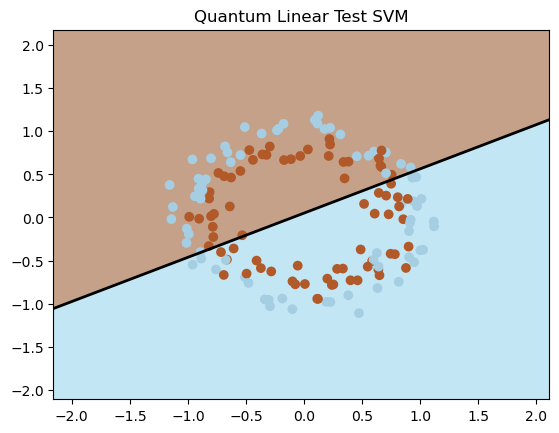

w = [-0.45388429  0.88401729], b = -0.04502462160112255
Test Accuracy : 0.4800
Test AUROC    : 0.4512
Test AUPRC    : 0.4524
w = [-0.45388429  0.88401729], b = -0.04502462160112255


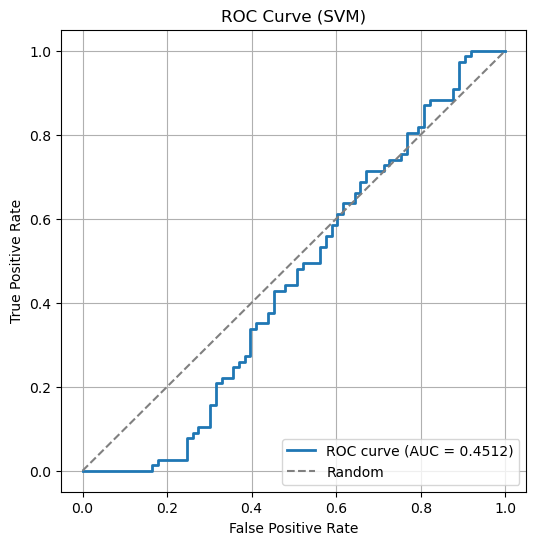

In [ ]:
Test_Graph(alpha, K_train_train)

Evaluate(alpha, K_train_train)